In [112]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
import astropy.units as u
from astropy.units import cds

import mwa_hyperbeam

c = cds.c

# Forward simulation (model horizon --> visibilities)

## Get the antenna positions

In [36]:
hdul = fits.open("1164110416.metafits")
N = hdul[1].data["north"][::2] * u.m
E = hdul[1].data["east"][::2] * u.m
hdul.close()

nant = len(N)

## Construct a horizon (RFI) function

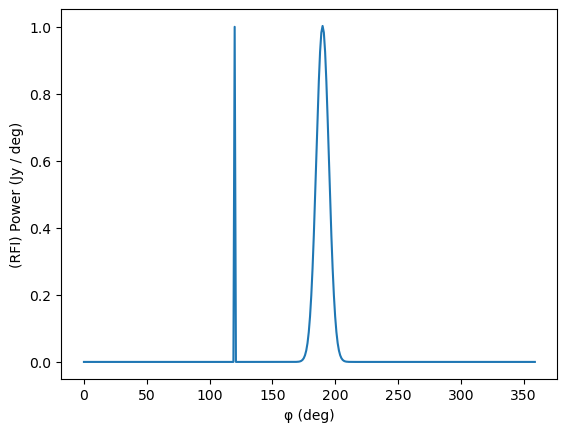

In [101]:
# Let φ be the compass bearing (angle from North towards East)
φ = np.linspace(0, 360, num=360, endpoint=False) * u.degree
dφ = 360/len(φ) * u.degree

# A point-like RFI source at about bearing 120°
RFI_1 = np.zeros(φ.shape) * u.Jy / dφ
RFI_1[len(φ)//3] = 1 * u.Jy / dφ

# A diffuse, Gaussian source centred at 190°
σ = 5 * u.degree
μ = 190 * u.degree
A = 2 * u.Jy / dφ
RFI_2 = A * (dφ / σ*np.sqrt(2*np.pi)) * np.exp(-0.5*(φ - μ)**2 / σ**2)

# Total RFI
RFI = RFI_1 + RFI_2

plt.plot(φ, RFI)
plt.xlabel(f"φ ({φ.unit})")
plt.ylabel(f"(RFI) Power ({RFI.unit})")

# Let the RFI be at some particular frequency
ν = 150 * u.MHz
λ = c/ν

This function is what we're going to try and recover.

## Simulate the visibilities for each baseline

The interferometric measurement equation, for baseline $ij$:

$$ V_{ij} = \int_0^{2\pi} I(\vec{\varphi}) \, e^{-2\pi j \vec{D}_{ij,\lambda} \cdot \vec{\varphi}} \, \text{d}\varphi, $$

where
- $I(\vec{\varphi})$ is the RFI power per (1D) beam (in this case, `RFI`), multiplied by the beam (see below)
- $\vec{D}_{ij,\lambda}$ is the baseline vector (`Dλvec`)
- $\vec{\varphi}$ is the source direction (`φvec`)
- $j$ is doubling up both as one of the tile indices *and* as the complex number $\sqrt{-1}$

In [102]:
# The baseline vectors expressed in terms of number of wavelengths
# The coordinate system is (p,q), where p-hat is north and q-hat is east
Dλvec = [[((N[j] - N[i])/λ).decompose(),
          ((E[j] - E[i])/λ).decompose()] for i in range(nant-1) for j in range(i+1, nant)]

In [103]:
# The direction cosines
φvec = [[np.cos(φi), np.sin(φi)] for φi in φ]

### The beam response

For now, we will assume a zenith pointing.

In [157]:
# Adapted from https://github.com/MWATelescope/mwa_hyperbeam/blob/main/examples/fee.py

beam = mwa_hyperbeam.FEEBeam() # Assumes that the environment variable MWA_BEAM_FILE contains
                               # the path to the embedded element HDF5 file
delays = [0] * 16
amps = [1.0] * 16
norm_to_zenith = True
array_latitude_rad = None # Turns off parallactic angle correction
iau_order = False # Doesn't matter since parallactic angle correction is turned off

# Note on parallactic angle correction: we're assuming the RFI to be Stokes I, so we can get away with ignoring
# the parallactic angle correction altogether

az = (φ - 90*u.degree).to(u.radian).value # Hyperbeam wants directions measured from East instead of North
za = np.full(az.shape, np.pi/2) # i.e. the horizon

B = beam.calc_jones_array(az, za, ν.to(u.Hertz).value, delays, amps, norm_to_zenith, array_latitude_rad, iau_order)

# Reshape matrices from 4x1 to 2x2:
B = np.reshape(B, (-1, 2, 2))

# The units of the beam matrix are voltages per Jansky.
# The true scaling will be wrong because we're normalising to zenith, but it doesn't matter.
B_unit = u.V / u.Jy

1000 × |B[0]| = [[1.90013028 0.00448974]
 [0.00385193 2.9923019 ]]


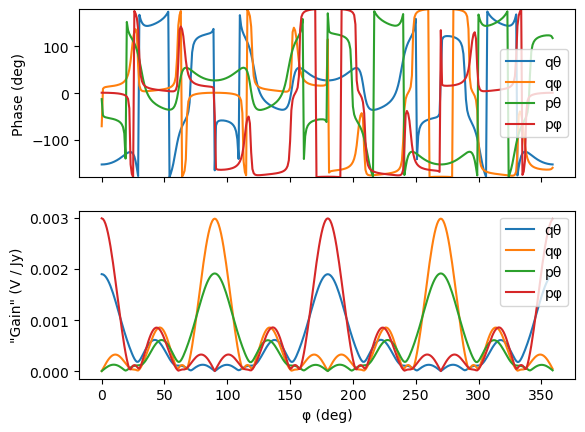

In [211]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)

axs[0].plot(φ, np.rad2deg(np.angle(B[:,0,0])), label="qθ")
axs[0].plot(φ, np.rad2deg(np.angle(B[:,0,1])), label="qφ")
axs[0].plot(φ, np.rad2deg(np.angle(B[:,1,0])), label="pθ")
axs[0].plot(φ, np.rad2deg(np.angle(B[:,1,1])), label="pφ")
#axs[0].set_xlabel(f"φ ({φ.unit})")
axs[0].set_ylabel(f"Phase (deg)")
axs[0].set_ylim([-180, 180])
axs[0].legend()

axs[1].plot(φ, np.abs(B[:,0,0]), label="qθ")
axs[1].plot(φ, np.abs(B[:,0,1]), label="qφ")
axs[1].plot(φ, np.abs(B[:,1,0]), label="pθ")
axs[1].plot(φ, np.abs(B[:,1,1]), label="pφ")
axs[1].set_ylabel(f"\"Gain\" ({B_unit})")
axs[1].legend()

axs[-1].set_xlabel(f"φ ({φ.unit})")

# Print out the first matrix's amplitudes, just to get a sense
print("1000 × |B[0]| =", np.abs(B[0])*1e3)

Now, we apply the beam to the RFI power, assumed to be Stokes I.

Be aware that in the following, ${\bf I}$ is the total instrumental response, whereas $S_I$ is Stokes I, etc.

In [163]:
S_I = RFI
S_Q = np.zeros(RFI.shape) * RFI.unit
S_U = np.zeros(RFI.shape) * RFI.unit
S_V = np.zeros(RFI.shape) * RFI.unit

# The coherency matrix (a reminder that for Stokes I sources, parallactic angle can be ignored)
eeH = [0.5 * np.array([[S_I[i] + S_Q[i], S_U[i] - S_V[i]*1j], [S_U[i] + S_V[i]*1j, S_I[i] - S_Q[i]]])
       for i in range(len(RFI))]

I = np.array([B[i] @ eeH[i] @ np.linalg.pinv(B[i]) for i in range(len(B))])

$I$ is now the instrumental response (for MWA-style cross dipoles) as a function of look-direction around the horizon.
It is an array of $2 \times 2$ matrices, whose outermost dimension is the number of look directions.

### Putting it all together

For our discretely sampled $I(\vec{\varphi})$, the integral becomes a sum over $n$ directions:

$$ V_{ij} = \sum_n I_n \, e^{-2\pi j \vec{D}_{ij,\lambda} \cdot \vec{\varphi}_n} \, \Delta\varphi, $$

This resembles a DFT, but it isn't a DFT because $\vec{D}_{ij,\lambda} \cdot \vec{\varphi}_n$ is not linear in $n$.
In fact, it is $|\vec{D}_\lambda|\,\cos(\varphi_n - \theta_{ij})$, where $|\vec{D}_{ij,\lambda}|$ is the baseline length, and $\theta_{ij}$ is the baseline direction.

So, because we cannot use an FFT to compute this, we compute it directly as a matrix multiplication:

$$ {\bf V}_{ij} = {\bf T}_{ij,n} {\bf I}_n \, \Delta\varphi, $$

or, without the explicit indices,

$$ {\bf V} = {\bf T} {\bf I} \, \Delta\varphi, $$

where
- ${\bf T}$ is the matrix of twiddle factors for baseline $ij$ and direction $n$ (`tw`).

In [106]:
# The twiddle factors (WARNING: takes a while to run!)
tw = np.array([[np.exp(-1j*2*np.pi*np.dot(Dλ, φvec[i])) for i in range(len(φ))] for Dλ in Dλvec])

In [230]:
# Construct the visibilities (the einsum is necessary because I and V are themselves arrays of matrices)
V = np.einsum('in,njk', tw, I) * dφ * u.V / u.degree

# Add noise
noise_amp = 5.0
V += noise_amp*(np.random.randn(*V.shape) +
                np.random.randn(*V.shape)*1j) * u.V

# Recovering the horizon (visibilities --> model)

## Apply the beam correction

In this simulation, we have used the same beam for all tiles, but this can be generalised in case of dead dipoles, etc.

In [231]:
# Beam-corrected visilibities
Vb = np.array([np.linalg.pinv(B[i]) @ V[i] @ B[i] for i in range(len(B))])

The beam corrected visilibities ${\bf V}_b = {\bf B}^{-1} {\bf V} {\bf B}$ (or, in the code, `Vb`).

## Test least squares inversion

To recover the horizon power, we need to invert the matrix equation above. One method is to use least squares:

$$ \tilde{\bf I} = ({\bf T}^T {\bf T})^{-1} {\bf T}^T {\bf V}_b \, \Delta\varphi^{-1} $$

In [238]:
# If I and V weren't arrays of matrices, then the above could be implemented using the very readable line:
#     Itilde = np.linalg.pinv(tw.T @ tw) @ tw.T @ V / dφ
# However, this needs an einsum, so we'll pre-calculate all of the terms involving just the T first,
# which we can do without einsum:
#     (T^T @ T)^{-1} T^T
TTTTT = np.linalg.pinv(tw.T @ tw) @ tw.T / dφ
# And then use an einsum for the final matrix multiplication:
Itilde = np.einsum('nk,kpq', TTTTT, V)

# Make them hermitian (equiv. to including "reverse" baselines)
Itilde = (Itilde + np.conj(np.transpose(Itilde, axes=(0,2,1)))) / B_unit

In [239]:
# And thence the reconstructed Stokes parameters
# Ignoring the factor of half, since we're only using half the baselines
tilde_S_I = 0.5*(Itilde[:,0,0] + Itilde[:,1,1])
tilde_S_Q = 0.5*(Itilde[:,0,0] - Itilde[:,1,1])
tilde_S_U = 0.5*(Itilde[:,0,1] + Itilde[:,1,0])
tilde_S_V = 0.5j*(Itilde[:,1,0] - Itilde[:,0,1])

Text(0.5, 0, 'φ (deg)')

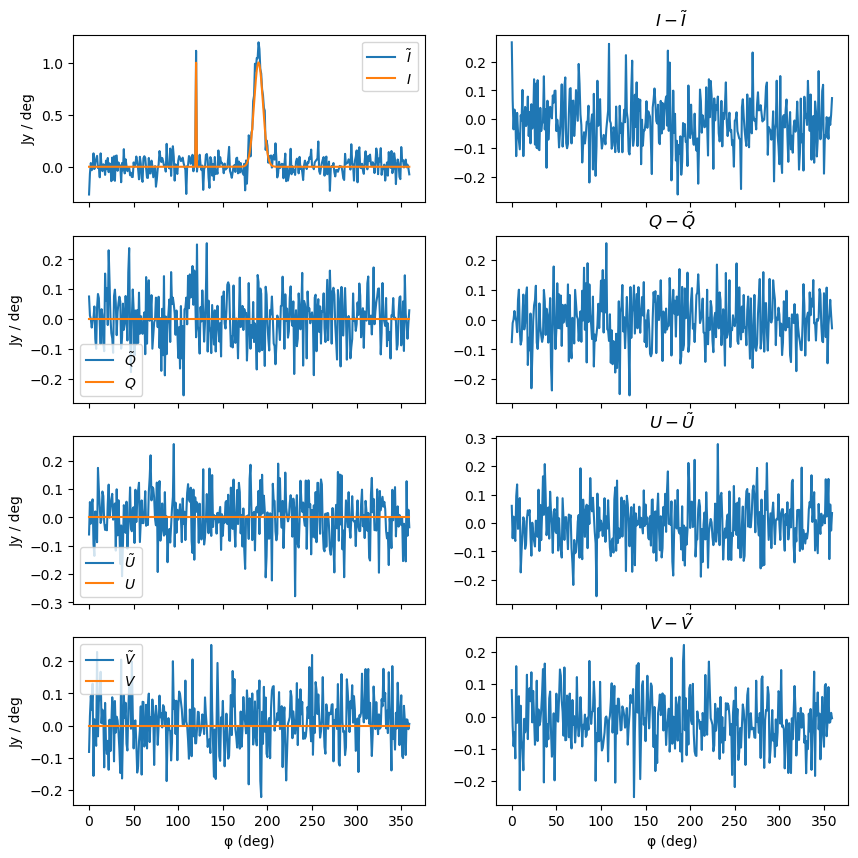

In [245]:
# Plot things up
fig, axs = plt.subplots(nrows=4, ncols=2, sharex=True, figsize=(10,10))

# Plots of the true signal and the recovered signal
axs[0][0].plot(φ, tilde_S_I, label="$\\tilde{I}$")
axs[0][0].plot(φ, S_I, label="$I$")
axs[0][0].set_ylabel(f"{RFI.unit}")
axs[0][0].legend()

axs[1][0].plot(φ, tilde_S_Q, label="$\\tilde{Q}$")
axs[1][0].plot(φ, S_Q, label="$Q$")
axs[1][0].set_ylabel(f"{RFI.unit}")
axs[1][0].legend()

axs[2][0].plot(φ, tilde_S_U, label="$\\tilde{U}$")
axs[2][0].plot(φ, S_U, label="$U$")
axs[2][0].set_ylabel(f"{RFI.unit}")
axs[2][0].legend()

axs[3][0].plot(φ, tilde_S_V, label="$\\tilde{V}$")
axs[3][0].plot(φ, S_V, label="$V$")
axs[3][0].set_ylabel(f"{RFI.unit}")
axs[3][0].legend()

# Plots of the _difference_ between the true signal and the recovered signal
axs[0][1].plot(φ, S_I - tilde_S_I)
axs[0][1].set_title("$I - \\tilde{I}$")

axs[1][1].plot(φ, S_Q - tilde_S_Q)
axs[1][1].set_title("$Q - \\tilde{Q}$")

axs[2][1].plot(φ, S_U - tilde_S_U)
axs[2][1].set_title("$U - \\tilde{U}$")

axs[3][1].plot(φ, S_V - tilde_S_V)
axs[3][1].set_title("$V - \\tilde{V}$")

axs[-1][0].set_xlabel(f"φ ({φ.unit})")
axs[-1][1].set_xlabel(f"φ ({φ.unit})")
